# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

### this project was developed through google's colab notebooks

In [0]:
#mounting drive to my google colab notebook to retrieve data stored in my google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Importing libraries

In [0]:
# import libraries here; add more as necessary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc


import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
import lightgbm as lgb
from sklearn import pipeline

from sklearn import metrics
from sklearn.metrics import roc_auc_score

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

import pickle

from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer


%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### loading in the data and starting data exploration

In [0]:
# load in the data
azdias = pd.read_csv('/content/drive/My Drive/data capstone/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)

In [0]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,NaN,0,0,0,...,NaN,NaN,5.0,1.0,4.0,1.0,6,3,6,6,7,3,5,5,5,4,7,2,3,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8A,8,51,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,0,0,10,0,0,0,10,10,NaN,0,0,0,...,3.0,4.0,1.0,5.0,3.0,5.0,7,2,4,4,4,3,2,3,7,6,4,5,6,1,3,1.0,2.0,0.0,3.0,3.0,1.0,0.0,2,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4C,4,24,3.0,2.0,4.0,4.0,1.0,3.0,2.0,2.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,2.0,2.0,3.0,5.0,4.0,5.0,7,6,1,7,7,3,4,3,3,4,3,4,3,4,2,0.0,3.0,0.0,2.0,5.0,0.0,1.0,1,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,2A,2,12,2.0,3.0,2.0,2.0,4.0,4.0,5.0,3.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,0.0,3.0,2.0,3.0,2.0,3.0,4,7,1,5,4,4,4,1,4,3,2,5,4,4,1,0.0,1.0,0.0,4.0,5.0,0.0,0.0,1,1.0,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,6B,6,43,5.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3,5,5,1,2,0,10,5,10.0,6,6,1,...,5.0,5.0,5.0,3.0,5.0,5.0,2,4,4,2,3,6,4,2,4,2,4,6,2,7,2,0.0,3.0,0.0,4.0,3.0,0.0,1.0,2,0.0,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [0]:
azdias.shape

(891221, 366)

In [0]:
#set the LNR column as the index as it has a unique value for each row and will not help in the analysis
azdias.set_index('LNR', inplace = True)

In [0]:
azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,NaN,0,0,0,0,...,NaN,NaN,5.0,1.0,4.0,1.0,6,3,6,6,7,3,5,5,5,4,7,2,3,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8A,8,51,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,0,0,10,0,0,0,10,10,NaN,0,0,0,0,...,3.0,4.0,1.0,5.0,3.0,5.0,7,2,4,4,4,3,2,3,7,6,4,5,6,1,3,1.0,2.0,0.0,3.0,3.0,1.0,0.0,2,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4C,4,24,3.0,2.0,4.0,4.0,1.0,3.0,2.0,2.0,0,0,10,0,0,0,10,10,0.0,0,0,0,6,...,2.0,2.0,3.0,5.0,4.0,5.0,7,6,1,7,7,3,4,3,3,4,3,4,3,4,2,0.0,3.0,0.0,2.0,5.0,0.0,1.0,1,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,2A,2,12,2.0,3.0,2.0,2.0,4.0,4.0,5.0,3.0,0,0,10,0,0,0,10,10,0.0,0,0,0,0,...,0.0,3.0,2.0,3.0,2.0,3.0,4,7,1,5,4,4,4,1,4,3,2,5,4,4,1,0.0,1.0,0.0,4.0,5.0,0.0,0.0,1,1.0,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,6B,6,43,5.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3,5,5,1,2,0,10,5,10.0,6,6,1,6,...,5.0,5.0,5.0,3.0,5.0,5.0,2,4,4,2,3,6,4,2,4,2,4,6,2,7,2,0.0,3.0,0.0,4.0,3.0,0.0,1.0,2,0.0,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [0]:
azdias.shape

(891221, 365)

### read the excel file that contains the feature and values attributes

In [0]:
#read the excel file
feat_info = pd.read_excel('/content/drive/My Drive/data capstone/DIAS Attributes - Values 2017.xlsx', sep=';',
                          columns = ['Attribute','Description','Value','Meaning'])

#getting rid of the first blank column
feat_info = feat_info.iloc[:,1:]

#setting first row as the dataframe columns as it contained the column names
feat_info.columns = feat_info.iloc[0]

#getting rid of a blank column
feat_info = feat_info.drop(0).reset_index()

In [0]:
#display head of the data
feat_info.head(10)

,index,Attribute,Description,Value,Meaning
0,1,AGER_TYP,best-ager typology,-1,unknown
1,2,NaN,NaN,0,no classification possible
2,3,NaN,NaN,1,passive elderly
3,4,NaN,NaN,2,cultural elderly
4,5,NaN,NaN,3,experience-driven elderly
5,6,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,7,NaN,NaN,1,< 30 years
7,8,NaN,NaN,2,30 - 45 years
8,9,NaN,NaN,3,46 - 60 years
9,10,NaN,NaN,4,> 60 years


### querying rows that have unknown in the meaning column indicating that value should be NaN

In [0]:
#querying rows that have unknown in the meaning column indicating that value should be NaN
feat_info = feat_info.loc[feat_info['Meaning'] == 'unknown']

In [0]:
#checking shape of features dataframe
feat_info.shape

(232, 5)

In [0]:
feat_info.head()

,index,Attribute,Description,Value,Meaning
0,1,AGER_TYP,best-ager typology,-1,unknown
5,6,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,34,ANREDE_KZ,gender,"-1, 0",unknown
40,41,BALLRAUM,distance to next urban centre,-1,unknown
48,49,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown


In [0]:
#setting datatype to str
feat_info.Value = feat_info.Value.astype('str')

In [0]:
#splitting values by ',' therefore creating a list of values in each column and getting rid of the ',''
feat_info.Value = feat_info.Value.str.split(',') 

In [0]:
feat_info.head()

,index,Attribute,Description,Value,Meaning
0,1,AGER_TYP,best-ager typology,[-1],unknown
5,6,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0]",unknown
33,34,ANREDE_KZ,gender,"[-1, 0]",unknown
40,41,BALLRAUM,distance to next urban centre,[-1],unknown
48,49,BIP_FLAG,business-flag indicating companies in the buil...,[-1],unknown


### Identify missing or unknown data values and convert them to NaNs.

In [0]:
def replace_unknown_with_nan(df, feat_df, feat_name, feat_missing_value):
    """
    objective : 
    
        replaces unknown values in a dataframe with NaN
    
    input:
    
        df: dataframe to replace unknown values with NaN in 
        
        feat_df: features dataframe to map values needed to be replaces
        
        feat_name: name of Attribute column in feat_df to map columns in df to search and replace
        
        feat_missing_value: name of value column in feat_df to map columns in df to search and replace
        
        
    output:
        
        returns: 
        
            dataframe with after rplacing unknown values with NaN
    
    """
    # For each mapper_df row definition
    for index, row in feat_df.iterrows():
        # Omit rows with no NaNs or with lists without values
        if len(row[feat_missing_value]) > 0 and row[feat_missing_value] != ['']:
            try:
                # For each column definition
                # build a list of nan_indicators
                masked_values = []
                for nan_indicator in row[feat_missing_value]:
                    
                    masked_values.append(int(nan_indicator))
                
                #print(replace_mask)
                # Replace masked values with NaN
                df[row[feat_name]] = df[row[feat_name]].replace(masked_values, np.nan)
                
            except Exception as e:
                #print('Exception: {} -> {} --> {}'.format(row[feat_name], str(e), nan_indicator))
                continue
                
    return df

In [0]:
#apply cleaning function on the azdias dataframe
azdias = replace_unknown_with_nan(azdias, feat_info, 'Attribute', 'Value')

In [0]:
#clean up memory
gc.collect()

4707

### assessing missing data


In [0]:
#creating dataframe that holds column names and their respective missing values

#create a series of null values in the dataframe
total_azdias = azdias.isnull().sum().sort_values(ascending=False)

#create a series of null values percentage in the dataframe
percent_azdias = (azdias.isnull().sum()/azdias.isnull().count()).sort_values(ascending=False)

#combining both series together to create one dataframe
missing_data_azdias = pd.concat([total_azdias, percent_azdias], axis=1, keys=['Total', 'Percent']) 

In [0]:
missing_data_azdias.head(10)

,Total,Percent
ALTER_KIND4,890016,0.998648
TITEL_KZ,889061,0.997576
ALTER_KIND3,885051,0.993077
ALTER_KIND2,861722,0.966900
ALTER_KIND1,810163,0.909048
AGER_TYP,677503,0.760196
EXTSEL992,654153,0.733996
KK_KUNDENTYP,584612,0.655967
KBA05_BAUMAX,476524,0.534687
ALTERSKATEGORIE_FEIN,262947,0.295041


### dropping rows with high null values at a threshold of 70% 
### and rows at a threshold of 75%

In [0]:
# storing rows to be dropped in a list to be used later in the cleaning function
columns_to_drop= ['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'ALTER_KIND2',
                  'ALTER_KIND1','AGER_TYP', 'EXTSEL992', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

In [0]:
#drop colums with 30% or more missing data
#drop rows with 25% or more missing data

print('(orig) azdias rows, cols: ', azdias.shape)

azdias.drop(columns_to_drop, axis=1, inplace=True)
azdias.dropna(axis=0, thresh = 0.75 * azdias.shape[1], inplace=True)

print('(dropped) azdias rows, cols: ', azdias.shape)


(orig) azdias rows, cols:  (891221, 365)
(dropped) azdias rows, cols:  (785302, 356)


### investigating categorical features

In [0]:
#investigate categorical columns indices

lst_azdias = []
for idx, typ in enumerate(azdias.dtypes.tolist()):
    if typ == 'O':
        lst_azdias.append(idx)
    
lst_azdias

[11, 12, 13, 55, 91, 308]

In [0]:
#investigate missing data in categorical data 

azdias.iloc[:,lst_azdias].isnull().sum()

CAMEO_DEU_2015                3648
CAMEO_DEUG_2015               3648
CAMEO_INTL_2015               3648
D19_LETZTER_KAUF_BRANCHE    175105
EINGEFUEGT_AM                    0
OST_WEST_KZ                      0
dtype: int64

In [0]:
#show head of categorical columns
azdias.iloc[:,lst_azdias].head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
LNR,,,,,,
910220,8A,8,51,NaN,1992-02-10 00:00:00,W
910225,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
910226,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
910241,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
910244,8C,8,54,D19_ENERGIE,1992-02-12 00:00:00,W


### after investigating the head columns ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'] however look like numerical data 

In [0]:

#investigate 'CAMEO_DEUG_2015' values

azdias['CAMEO_DEUG_2015'].value_counts(dropna = False)

#it seems there is a string 'X' in the data with 347 occurances

8      132939
9      106292
6      104749
4      102591
3       85412
2       82314
7       76807
5       54338
1       35865
NaN      3648
X         347
Name: CAMEO_DEUG_2015, dtype: int64

### it appears that it contained string values 'X' 
### will be changed to NaN

In [0]:
#replace str values in a numerical column with nan
azdias['CAMEO_DEUG_2015']= pd.to_numeric(azdias.CAMEO_DEUG_2015.astype(str).str.replace('.',''), errors='coerce')

In [0]:
azdias['CAMEO_DEUG_2015'].value_counts(dropna = False)

8.0    132939
9.0    106292
6.0    104749
4.0    102591
3.0     85412
2.0     82314
7.0     76807
5.0     54338
1.0     35865
NaN      3995
Name: CAMEO_DEUG_2015, dtype: int64

In [0]:
#investigating 'CAMEO_INTL_2015' values

azdias['CAMEO_INTL_2015'].value_counts(dropna = False)

#it seems there is a string 'XX' in the data with 347 occurances


51     131868
41      90978
24      90116
14      62197
43      56070
54      44852
25      39237
22      32649
13      26019
23      26001
45      25888
55      23367
52      20393
31      18577
34      18213
15      16853
44      14646
12      13110
35      10254
32      10240
33       9779
NaN      3648
XX        347
Name: CAMEO_INTL_2015, dtype: int64

In [0]:
#replace str values in a numerical column with nan
azdias['CAMEO_INTL_2015'] = pd.to_numeric(azdias.CAMEO_INTL_2015.astype(str).str.replace('.',''), errors='coerce')

In [0]:
azdias['CAMEO_INTL_2015'].value_counts(dropna = False)

51.0    131868
41.0     90978
24.0     90116
14.0     62197
43.0     56070
54.0     44852
25.0     39237
22.0     32649
13.0     26019
23.0     26001
45.0     25888
55.0     23367
52.0     20393
31.0     18577
34.0     18213
15.0     16853
44.0     14646
12.0     13110
35.0     10254
32.0     10240
33.0      9779
NaN       3995
Name: CAMEO_INTL_2015, dtype: int64

In [0]:
#investigating 'CAMEO_DEU_2015' values
azdias['CAMEO_DEU_2015'].value_counts(dropna=False)

#appears to have 'XX' values
#shall be converted into NaN

6B     56070
8A     51915
4C     47252
2D     34715
3C     34372
7A     33997
3D     33970
8B     32849
4A     32649
8C     30754
9D     28090
9B     27287
9C     24576
7B     24132
9A     20393
2C     19192
8D     17421
6E     15970
2B     15297
5D     14689
6C     14646
2A     13110
5A     11870
1D     11844
1A     10722
5B     10240
3A     10080
5C      9779
4B      8931
7C      8899
4D      8492
3B      6990
6A      6707
6D      6018
9E      5946
6F      5338
4E      5267
7D      5199
1E      5009
7E      4580
1C      4263
5F      4236
1B      4027
NaN     3648
5E      3524
XX       347
Name: CAMEO_DEU_2015, dtype: int64

In [0]:
#Convert 'XX' values into NaN
azdias['CAMEO_DEU_2015']  = azdias['CAMEO_DEU_2015'].replace('XX',np.nan)

In [0]:
#investigating 'CAMEO_DEU_2015' values
azdias['CAMEO_DEU_2015'].value_counts(dropna=False)

6B     56070
8A     51915
4C     47252
2D     34715
3C     34372
7A     33997
3D     33970
8B     32849
4A     32649
8C     30754
9D     28090
9B     27287
9C     24576
7B     24132
9A     20393
2C     19192
8D     17421
6E     15970
2B     15297
5D     14689
6C     14646
2A     13110
5A     11870
1D     11844
1A     10722
5B     10240
3A     10080
5C      9779
4B      8931
7C      8899
4D      8492
3B      6990
6A      6707
6D      6018
9E      5946
6F      5338
4E      5267
7D      5199
1E      5009
7E      4580
1C      4263
5F      4236
1B      4027
NaN     3995
5E      3524
Name: CAMEO_DEU_2015, dtype: int64

In [0]:
#investigating 'D19_LETZTER_KAUF_BRANCHE'

azdias['D19_LETZTER_KAUF_BRANCHE'].value_counts()



D19_UNBEKANNT             188135
D19_VERSICHERUNGEN         55651
D19_SONSTIGE               43044
D19_VOLLSORTIMENT          33454
D19_SCHUHE                 31204
D19_BUCH_CD                27735
D19_VERSAND_REST           25057
D19_DROGERIEARTIKEL        23136
D19_BANKEN_DIREKT          22395
D19_BEKLEIDUNG_REST        20888
D19_HAUS_DEKO              20097
D19_TELKO_MOBILE           13904
D19_ENERGIE                11676
D19_TELKO_REST             11064
D19_BANKEN_GROSS           10140
D19_BEKLEIDUNG_GEH          9859
D19_KINDERARTIKEL           6978
D19_FREIZEIT                6964
D19_TECHNIK                 6730
D19_LEBENSMITTEL            6210
D19_BANKEN_REST             5041
D19_RATGEBER                4744
D19_NAHRUNGSERGAENZUNG      3932
D19_DIGIT_SERV              3453
D19_REISEN                  2999
D19_TIERARTIKEL             2480
D19_SAMMELARTIKEL           2349
D19_HANDWERK                2150
D19_WEIN_FEINKOST           2087
D19_GARTEN                  1578
D19_BANKEN

### since this column refers to only the LAST purchase made
### since there are columns in the data frame for every category in this column
### since this column is not refrenced in the values excell sheet provided in the project
### since around 25% of this column's values are under "D19_UNBEKANNT" which means 
### that we cannot derive the category of the purchase
### this column will be omitted from the analysis  

In [0]:
#investigating 'EINGEFUEGT_AM'
azdias['EINGEFUEGT_AM'].value_counts()



1992-02-10 00:00:00    380331
1992-02-12 00:00:00    190718
1995-02-07 00:00:00     11125
2005-12-16 00:00:00      6199
2003-11-18 00:00:00      5958
                        ...  
2005-12-11 00:00:00         1
2001-01-29 00:00:00         1
2011-07-27 00:00:00         1
2009-12-21 00:00:00         1
2007-10-14 00:00:00         1
Name: EINGEFUEGT_AM, Length: 4464, dtype: int64

### date values
### almost 50% of the data is concentared on 2 dates that are 2 only days apart 
### also , is not mentioned in the values excel sheet provided in the project
### will not be included in the analysis

In [0]:
#dropping columns
azdias.drop(columns = ['D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM'], inplace = True)

In [0]:
#further investigate categorical columns indices

lst_azdias = []
for idx, typ in enumerate(azdias.dtypes.tolist()):
    if typ == 'O':
        lst_azdias.append(idx)
    
lst_azdias

[11, 306]

In [0]:
azdias.iloc[:,lst_azdias].head(10)

,CAMEO_DEU_2015,OST_WEST_KZ
LNR,,
910220,8A,W
910225,4C,W
910226,2A,W
910241,6B,W
910244,8C,W
910248,4A,W
910261,2D,W
645145,1A,W
645153,1E,W


In [0]:
azdias.shape

(785302, 354)

### re encoding categorical features

In [0]:
#investigating 'OST_WEST_KZ' values
azdias['OST_WEST_KZ'].value_counts(dropna=False)

W    619190
O    166112
Name: OST_WEST_KZ, dtype: int64

In [0]:
#instantiate a LabelEncoder object to re-enncode categorical features
le = LabelEncoder()

In [0]:
#re-ecnoding categorical column 'OST_WEST_KZ' to binary i.e [0,1]
azdias['OST_WEST_KZ'] = le.fit_transform(azdias['OST_WEST_KZ'].astype('str'))

In [0]:
#check values after re-encoding
azdias['OST_WEST_KZ'].value_counts()

1    619190
0    166112
Name: OST_WEST_KZ, dtype: int64

In [0]:
#investigating 'CAMEO_DEU_2015' values
azdias['CAMEO_DEU_2015'].value_counts(dropna=False)

6B     56070
8A     51915
4C     47252
2D     34715
3C     34372
7A     33997
3D     33970
8B     32849
4A     32649
8C     30754
9D     28090
9B     27287
9C     24576
7B     24132
9A     20393
2C     19192
8D     17421
6E     15970
2B     15297
5D     14689
6C     14646
2A     13110
5A     11870
1D     11844
1A     10722
5B     10240
3A     10080
5C      9779
4B      8931
7C      8899
4D      8492
3B      6990
6A      6707
6D      6018
9E      5946
6F      5338
4E      5267
7D      5199
1E      5009
7E      4580
1C      4263
5F      4236
1B      4027
NaN     3995
5E      3524
Name: CAMEO_DEU_2015, dtype: int64

#### missing values have to be imputed before re-enconding as LabelEncoder will encode NaN values
#### strategy will be imputing the NaN values with the most occuring value as this is the most common practice to impute categorical data

In [0]:
#imputing missing values with value most occuring
azdias['CAMEO_DEU_2015'] = azdias['CAMEO_DEU_2015'].fillna(azdias['CAMEO_DEU_2015'].value_counts().index[0])

In [0]:
azdias['CAMEO_DEU_2015'].value_counts().count()

44

In [0]:
#re-encoding 'CAMEO_DEU_2015' into numbers instead of categories
azdias['CAMEO_DEU_2015'] = le.fit_transform(azdias['CAMEO_DEU_2015'].astype('str'))

In [0]:
azdias['CAMEO_DEU_2015'].value_counts().count()

44

In [0]:
#investigating binary columns ['VERS_TYP']
azdias['VERS_TYP'].value_counts()

2.0    389009
1.0    360215
Name: VERS_TYP, dtype: int64

In [0]:
# investigating binary column ['ANREDE_KZ']
azdias['ANREDE_KZ'].value_counts()

2    409631
1    375671
Name: ANREDE_KZ, dtype: int64

In [0]:
#standardizing binary into 0,1
azdias['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
azdias['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)

In [0]:
#checking results 
azdias['VERS_TYP'].value_counts()

1.0    389009
0.0    360215
Name: VERS_TYP, dtype: int64

In [0]:
azdias['ANREDE_KZ'].value_counts()

1    409631
0    375671
Name: ANREDE_KZ, dtype: int64

In [0]:
gc.collect()

0

In [0]:
azdias.shape

(785302, 354)

### Remove redundancies
#### in the attribute llist I have noticed duplicated attributes with suffixes _FEIN and _GROB
#### with values similar and redundant 
#### investigating these attributes ['LP_STATUS_GROB','LP_FAMILIE_GROB','LP_LEBENSPHASE_GROB','ALTERSKATEGORIE_GROB']
#### and their potential duplicates ['LP_STATUS_FEIN','LP_FAMILIE_FEIN','LP_LEBENSPHASE_FEIN','ALTERSKATEGORIE_FEIN']

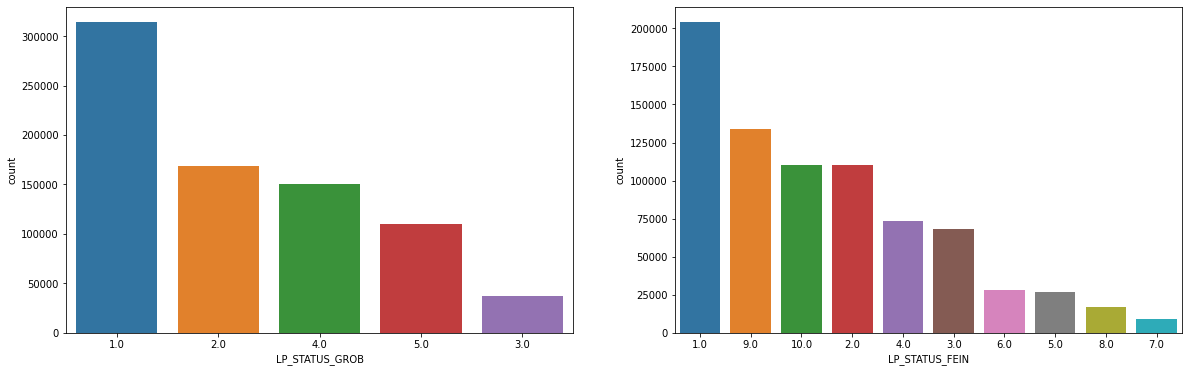

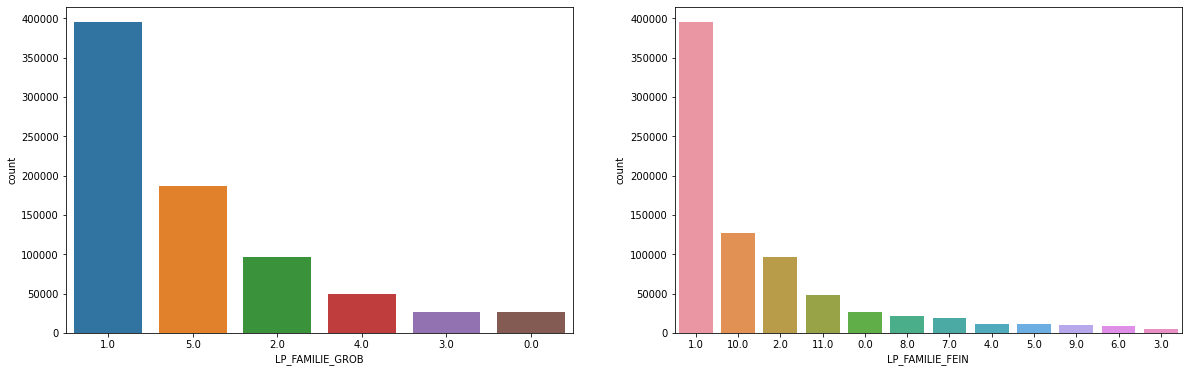

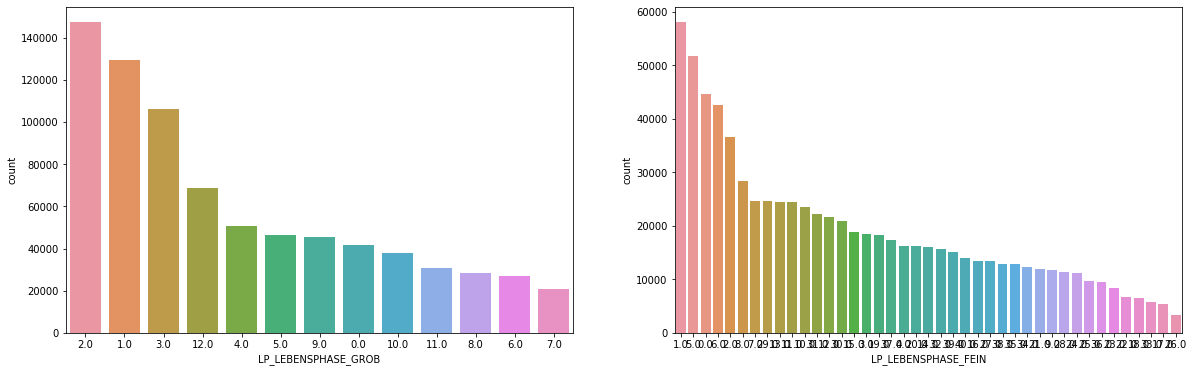

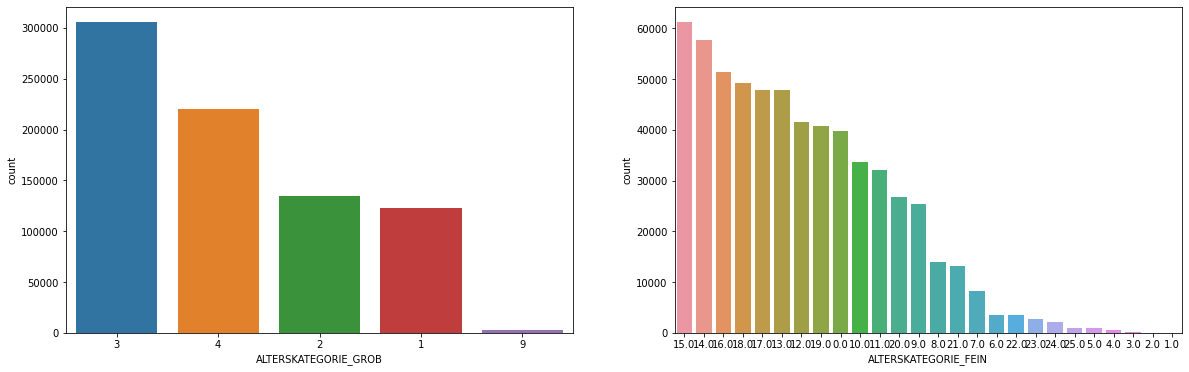

In [0]:
#visualising said features


#creating list of features to visualize
columns = [['LP_STATUS_GROB','LP_STATUS_FEIN'], ['LP_FAMILIE_GROB','LP_FAMILIE_FEIN'],
           ['LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN'],['ALTERSKATEGORIE_GROB','ALTERSKATEGORIE_FEIN']]


#iterating over values in columns list and plotting them
for group in columns:
    
    fig = plt.figure(figsize=(20, 6))
    
    ax1 = fig.add_subplot(121)
    sns.countplot(azdias[group[0]],order=azdias[group[0]].value_counts().index)

    ax2 = fig.add_subplot(122)
    sns.countplot(azdias[group[1]],order=azdias[group[1]].value_counts().index)

    plt.show();



#### as seen from above count plots and as inspected from the attribute sheet given by the project 
#### both the _GROB and the _FEIN describe the same thing except the _FEIN column is more fine grained
#### keeping one of them is enough
#### I have decided to drop ['LP_STATUS_GROB' ,LP_FAMILIE_GROB, 'LP_LEBENSPHASE_GROB'] as theoir respective columns suffice
#### and ['ALTERSKATEGORIE_FEIN'] as it is not it is not described in the attribute sheet

In [0]:
#dropping said columns
azdias.drop(['LP_STATUS_GROB' ,'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB', 'ALTERSKATEGORIE_FEIN'], axis=1, inplace=True)


### outlier removal

In [0]:
#investigate ['GEBURTSJAHR']
azdias['GEBURTSJAHR'].value_counts()

0       304715
1967     10749
1965     10685
1966     10542
1970     10478
         ...  
1908         6
1904         5
1907         3
1900         3
1902         1
Name: GEBURTSJAHR, Length: 117, dtype: int64

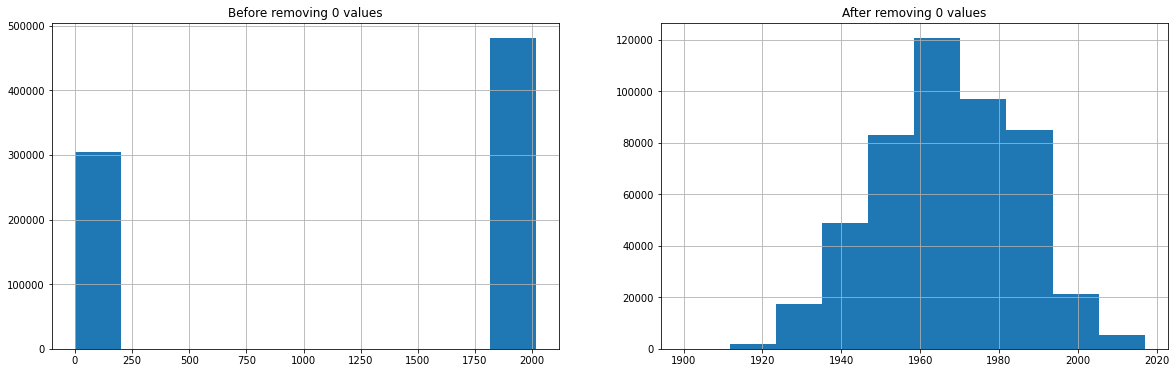

In [0]:
#visualizing values of ['GEBURTSJAHR'] (year of birth)

fig = plt.figure(figsize=(20, 6))

ax1 = fig.add_subplot(121)
azdias["GEBURTSJAHR"].hist(bins=10)
ax1.title.set_text('Before removing 0 values')

ax2 = fig.add_subplot(122)
azdias["GEBURTSJAHR"].replace(0,np.nan).hist()
ax2.title.set_text('After removing 0 values')


#there seems to be almost 40% '0' values in yeard of birth column

#### there seems to be almost 40% '0' values in yeard of birth column which is unreasonable , will re-encode them to NaN values

In [0]:
#re-encoding '0' values with NaN
azdias["GEBURTSJAHR"] = azdias["GEBURTSJAHR"].replace(0,np.nan)


In [0]:
#check that there is no unreasonable year of birth
print('minimum value is:',azdias["GEBURTSJAHR"].min())

#calculating null values percentage in the column
null_percentage = azdias["GEBURTSJAHR"].isnull().sum() /len(azdias["GEBURTSJAHR"]) *100
print('percentage of null vaues is :',null_percentage)


minimum value is: 1900.0
percentage of null vaues is : 38.802269700064436


#### however that would excceed the threshold set for columns with missing values and while the year of birth is obviously important to a customer satistical analysis , the values of birth years are almost normal disturbuted and  imputing such a high percentage of missing values will introduce bias, Therefore, will be dropped

In [0]:
#clear memory
del null_percentage
gc.collect()

29476

In [0]:
#dropping ['GEBURTSJAHR'] column
azdias.drop('GEBURTSJAHR', axis=1, inplace=True)

In [0]:
azdias.shape

(785302, 349)

In [0]:
gc.collect()

0

### engineer mixed types

#### Investigate CAMEO_INTL_2015 and engineer two new variables

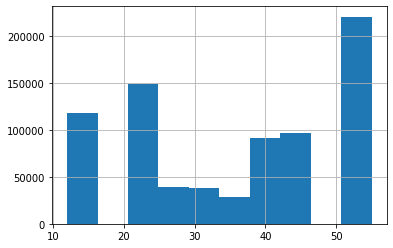

In [0]:
azdias['CAMEO_INTL_2015'].hist()

In [0]:
azdias.shape

(785302, 349)

In [0]:


#household wealth dictionary to map values in column with new re-encoded value 
households= {0: [11,12,13,14,15], #wealthy households
            1: [21,22,23,24,25], #properous households
            2: [31,32,33,34,35], #comfrotable households
            3: [41,42,43,44,45], # Less Affluent households
            4: [51,52,53,54,550] #poorer households
            }

#create function to replace values in the column with encoded household wealth level
def classify_household(value):
    try:
        for key, values in households.items():
            if value in values:
                return key
    # In case value is NaN
    except ValueError:
        return np.nan

#stage dictionary to map values in column with new re-encoded value 
stages = {0: [11,21,31,41,51],#Pre-Family Couples & Singles
         1: [12,22,32,42,52], #Young Couples With Children
         2: [13,23,33,43,53], #Families With School Age Children
         3: [14,24,34,44,54], #Older Families &  Mature Couples
         4: [15,25,35,45,55]# Elders In Retirement
         }

#create function to replace values in the column with encoded stage level
def classify_stage(value):
    try:
        for key, values in stages.items():
            if value in values:
                return key
    # In case value is NaN
    except ValueError:
        return np.nan

In [0]:
#create new column for household
azdias['CAMEO_INTL_2015_household']= azdias['CAMEO_INTL_2015'].apply(classify_household)

#create new column for stage
azdias['CAMEO_INTL_2015_stage']= azdias['CAMEO_INTL_2015'].apply(classify_stage)

In [0]:
azdias.shape

(785302, 351)

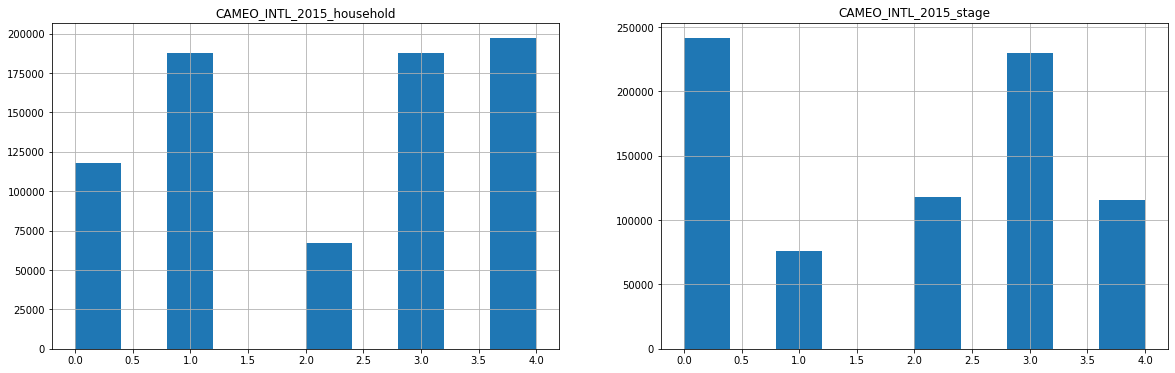

In [0]:
#visualizing newly created columns
fig = plt.figure(figsize=(20, 6))

ax1 = fig.add_subplot(121)
azdias["CAMEO_INTL_2015_household"].hist(bins=10)
ax1.title.set_text('CAMEO_INTL_2015_household')

ax2 = fig.add_subplot(122)
azdias["CAMEO_INTL_2015_stage"].hist()
ax2.title.set_text('CAMEO_INTL_2015_stage')



In [0]:
#drop orginal 'CAMEO_INTL_2015' column to evade multicollinearity 
azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [0]:
azdias.shape

(785302, 350)

####  Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

In [0]:


# Generation 
generations = {0: [1, 2], # 40s
               1: [3, 4], # 50s
               2: [5, 6, 7], # 60s
               3: [8, 9], # 70s
               4: [10, 11, 12, 13], # 80s
               5:[14, 15]} # 90s

def classify_generation(value):
    try:
        for key, values in generations.items():
            if value in values:
                return key
    # In case value is NaN
    except ValueError:
        return np.nan

# Movement 
mainstream = [1, 3, 5, 8, 10, 12, 14]

def classify_movement(value):
    try:
        if value in mainstream:
            return 1
        else:
            return 0
    # In case value is NaN
    except ValueError:
        return np.nan

In [0]:
# Engineer generation column
azdias['PRAEGENDE_JUGENDJAHRE_GEN'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(classify_generation)

# Engineer movement column
azdias['PRAEGENDE_JUGENDJAHRE_MOV'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(classify_movement)

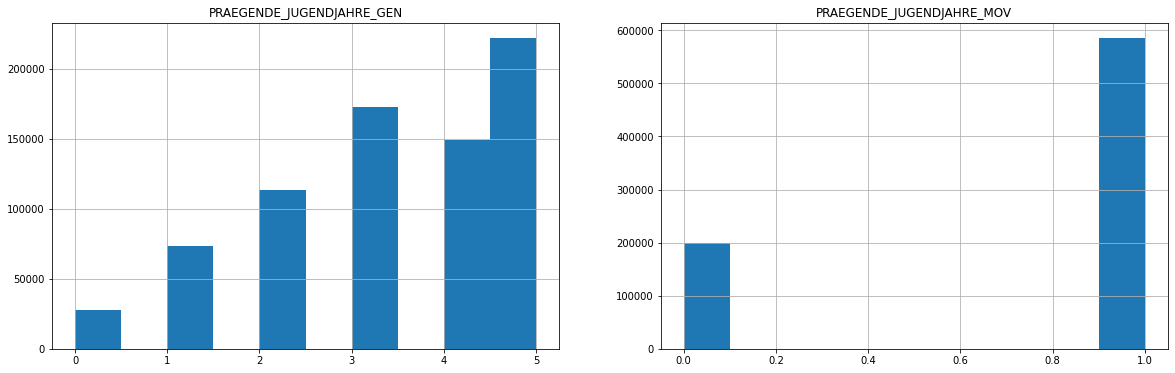

In [0]:
#visualizing two new columns

fig = plt.figure(figsize=(20, 6))

ax1 = fig.add_subplot(121)
azdias["PRAEGENDE_JUGENDJAHRE_GEN"].hist(bins=10)
ax1.title.set_text('PRAEGENDE_JUGENDJAHRE_GEN')

ax2 = fig.add_subplot(122)
azdias["PRAEGENDE_JUGENDJAHRE_MOV"].hist()
ax2.title.set_text('PRAEGENDE_JUGENDJAHRE_MOV')


In [0]:
#drop originnal 'PRAEGENDE_JUGENDJAHRE' column
azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [0]:
azdias.shape

(785302, 351)

#### Investigate 'LP_LEBENSPHASE_FEIN' and create two new ordinals features, one for life stage and other for scale

In [0]:



#encoding life stages
life_stage = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

#encoding fine scales
scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}





In [0]:
#mapping stages with codes
azdias['LP_LEBENSPHASE_FEIN_STAGE'] = azdias['LP_LEBENSPHASE_FEIN'].map(life_stage)
azdias['LP_LEBENSPHASE_FEIN_SCALE'] = azdias['LP_LEBENSPHASE_FEIN'].map(scale)



#drop orginal 'LP_LEBENSPHASE_FEIN'
azdias.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)

In [0]:
# Re-encode 'LP_LEBENSPHASE_FEIN_STAGE' and 'LP_LEBENSPHASE_FEIN_SCALE' as ordinal
dict_life_stage = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
dict_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}

In [0]:
#mapping values in columns with ordinal dictionaries
azdias['LP_LEBENSPHASE_FEIN_STAGE'] = azdias['LP_LEBENSPHASE_FEIN_STAGE'].map(dict_life_stage)
azdias['LP_LEBENSPHASE_FEIN_SCALE'] = azdias['LP_LEBENSPHASE_FEIN_SCALE'].map(dict_scale)

In [0]:
azdias.shape

(785302, 352)

### Imputing missing data
#### strategy will be to impute missing data with the most occuring value as most of the data in the dataframe are either binary or ordinal imputing with mean or median wil introduce complications and missinterpretation

In [0]:
#creating SimpleImputer object
imputer = SimpleImputer(missing_values= np.nan , strategy= 'most_frequent')

In [0]:
gc.collect()

12604

In [ ]:
#imputing missing values in azdias dataframe
azdias = pd.DataFrame(imputer.fit_transform(azdias.values), columns= azdias.columns)

In [0]:
#creating a new csv file for the imputed dataframe as the imputation was computationaly extensive
#azdias.to_csv('/content/drive/My Drive/data capstone/mode_imputed_azdias.csv',sep=',', columns=azdias.columns)

In [0]:
#loading in saved imputed dataframe
#azdias = pd.read_csv('/content/drive/My Drive/data capstone/mode_imputed_azdias.csv',sep=',')

In [0]:
#create cleaning function

def clean_data(df,feat_df,drop_rows=True):

    #set the LNR column as the index as it has a unique value for each row and will not help in the analysis
    df.set_index('LNR', inplace = True)

    #replace unkown values with NaN
    df = replace_unknown_with_nan(df, feat_df, 'Attribute', 'Value')

    #drop columns with 30% missing values or more
    df.drop(columns_to_drop, axis=1, inplace=True)
    #drop rows with 25% missing values or more if specified
    if drop_rows:
        df.dropna(axis=0, thresh = 0.75 * df.shape[1], inplace=True)
    
    #replace str values in a numerical column with nan
    df['CAMEO_DEUG_2015']= pd.to_numeric(df.CAMEO_DEUG_2015.astype(str).str.replace('.',''), errors='coerce')
    df['CAMEO_INTL_2015'] = pd.to_numeric(df.CAMEO_INTL_2015.astype(str).str.replace('.',''), errors='coerce')

    #Convert 'XX' values into NaN
    df['CAMEO_DEU_2015']  = df['CAMEO_DEU_2015'].replace('XX',np.nan)
    df.drop(columns = ['D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM'], inplace = True)

    #re-ecnoding categorical column 'OST_WEST_KZ' to binary i.e [0,1]
    df['OST_WEST_KZ'] = le.fit_transform(df['OST_WEST_KZ'].astype('str'))

    #missing values have to be imputed before re-enconding as LabelEncoder will encode NaN values
    #strategy will be imputing the NaN values with the most occuring value 
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].fillna(df['CAMEO_DEU_2015'].value_counts().index[0])

    #encoding 'CAMEO_DEU_2015' into numbers instead of categories
    df['CAMEO_DEU_2015'] = le.fit_transform(df['CAMEO_DEU_2015'].astype('str'))

    #standardizing binary into 0,1
    df['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
    df['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)

    #removing redundancies
    df.drop(['LP_STATUS_GROB' ,'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB', 'ALTERSKATEGORIE_FEIN'], axis=1, inplace=True)

    #dropping ['GEBURTSJAHR'] column as contains around 40% missing values
    df.drop('GEBURTSJAHR', axis=1, inplace=True)


    #create new column for household
    df['CAMEO_INTL_2015_household']= df['CAMEO_INTL_2015'].apply(classify_household)
    #create new column for stage
    df['CAMEO_INTL_2015_stage']= df['CAMEO_INTL_2015'].apply(classify_stage)
    #drop orginal 'CAMEO_INTL_2015' column to evade multicollinearity 
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)

    #Engineer generation column
    df['PRAEGENDE_JUGENDJAHRE_GEN'] = df['PRAEGENDE_JUGENDJAHRE'].apply(classify_generation)
    #Engineer movement column
    df['PRAEGENDE_JUGENDJAHRE_MOV'] = df['PRAEGENDE_JUGENDJAHRE'].apply(classify_movement)  
    #drop originnal 'PRAEGENDE_JUGENDJAHRE' column
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

    #mapping stages with codes
    df['LP_LEBENSPHASE_FEIN_STAGE'] = df['LP_LEBENSPHASE_FEIN'].map(life_stage)
    df['LP_LEBENSPHASE_FEIN_SCALE'] = df['LP_LEBENSPHASE_FEIN'].map(scale)
    # Re-encode 'LP_LEBENSPHASE_FEIN_STAGE' and 'LP_LEBENSPHASE_FEIN_SCALE' as ordinal
    df['LP_LEBENSPHASE_FEIN_STAGE'] = df['LP_LEBENSPHASE_FEIN_STAGE'].map(dict_life_stage)
    df['LP_LEBENSPHASE_FEIN_SCALE'] = df['LP_LEBENSPHASE_FEIN_SCALE'].map(dict_scale)
    #drop orginal 'LP_LEBENSPHASE_FEIN'
    df.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)

    #creating a dataframe of the imputed data
    df = pd.DataFrame(imputer.fit_transform(df.values), columns = df.columns)
    

    return df


In [0]:
#testing cleaning function

# load in original raw data
azdias = pd.read_csv('/content/drive/My Drive/data capstone/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)

In [0]:
#applying cleaning function 
clean_azdias= clean_data(azdias, feat_info)

In [0]:
clean_azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785302 entries, 0 to 785301
Columns: 352 entries, AKT_DAT_KL to LP_LEBENSPHASE_FEIN_SCALE
dtypes: float64(352)
memory usage: 2.1 GB


In [0]:
#clean memory
del azdias
gc.collect()

22

### Data scaling

In [0]:
#Robustscaler was chosen as it deals well with outliers

scaler = RobustScaler()

In [0]:
# scaling data and fitting to dataframe
scaled_azdias = pd.DataFrame(scaler.fit_transform(clean_azdias.values),
                          columns=clean_azdias.columns)

In [0]:
del clean_azdias
gc.collect()

0

### Dimensionality Reduction

In [0]:
#creating PCA object
pca = PCA()

#applying PCA and transforming dataframe
azdias_pca = pca.fit_transform(scaled_azdias)

In [0]:
#create scree plot to visualize variance in data

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components
    
    INPUT:
        pca - result of PCA on the dataframe
            
    OUTPUT:
        None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]),
                    va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

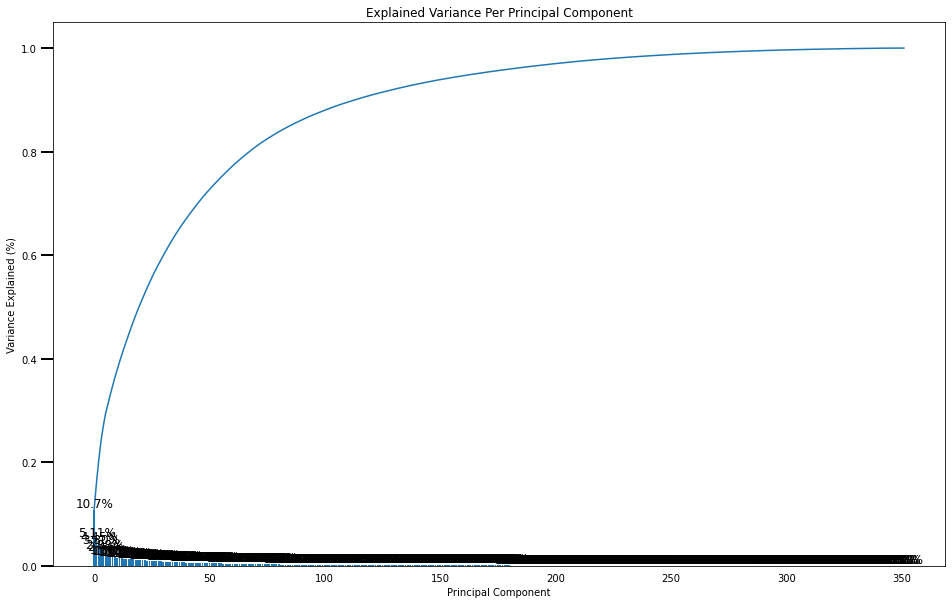

In [0]:
## Investigate the variance
scree_plot(pca)

In [0]:
for i in np.arange(10, 151, 10):
    print('{} components explain {} of variance.'.format(i, pca.explained_variance_ratio_[:i].sum()))

10 components explain 0.3634786012831484 of variance.
20 components explain 0.4950193071500208 of variance.
30 components explain 0.5912295405055974 of variance.
40 components explain 0.6646059341342521 of variance.
50 components explain 0.7219406888375272 of variance.
60 components explain 0.7680312603388463 of variance.
70 components explain 0.8059399829782563 of variance.
80 components explain 0.8356532932791838 of variance.
90 components explain 0.859074212908534 of variance.
100 components explain 0.8782656082774222 of variance.
110 components explain 0.8943102576676499 of variance.
120 components explain 0.9078097488522909 of variance.
130 components explain 0.9193271630108535 of variance.
140 components explain 0.929455158703063 of variance.
150 components explain 0.938297454458408 of variance.


In [0]:
print('{} components explain {} of variance.'.format(i, pca.explained_variance_ratio_[:115].sum()))

150 components explain 0.9012719012572511 of variance.


#### selected 90 components which captures almost 86% of variance

In [0]:
#re-do the pca process with the newly selected number of components
pca = PCA(n_components=90)

#applying pca to dataframe
azdias_pca = pca.fit_transform(scaled_azdias)

### Apply same steps to Customer data 

In [0]:
#load in customers data
customers = pd.read_csv('/content/drive/My Drive/data capstone/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)
customers.head()

In [0]:
customers.shape

In [0]:
#save and drop the extra columns not in azdias dataframe
extra_columns = customers[['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE']]
customers.drop(extra_columns,axis=1, inplace=True)

In [0]:
customers.shape

In [0]:
#clean customers dataframe
clean_customers= clean_data(customers, feat_info)

In [0]:
clean_customers.shape

In [0]:
#storing clean_customers dataframe to be reused later

#clean_customers.to_csv('/content/drive/My Drive/data capstone/uncorr_clean_customers.csv',sep=',', columns=clean_customers.columns)

In [0]:
#scale customers values
scaled_customers= pd.DataFrame(scaler.transform(clean_customers.values), columns= clean_customers.columns)

In [0]:
#apply pca 
customer_pca = pca.transform(scaled_customers)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Clustering and segmentation

#### Two clustering algorithims(Kmeans, GaussianMixtureModel) will be used and compared and best performance will be chosen

### Apply Kmeans

In [0]:
# Compute the average within-cluster distances.


def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    # instantiate kmeans
    kmeans = KMeans(n_clusters=center, random_state=42, n_jobs=-1)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [0]:
gc.collect()

28586

In [0]:
# Apply the elbow method
score_list = []
centers = np.arange(2, 15, 1)


for center in centers: 
    # Append score to score_list
    score_list.append(get_kmeans_score(azdias_pca, center))

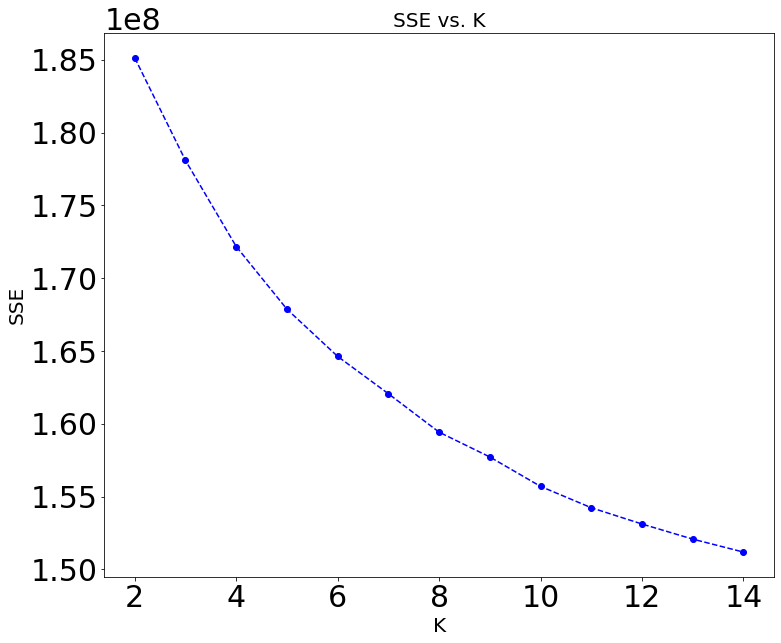

In [0]:
#create a figure for visualization 
plt.figure(figsize=(12, 10)) 
plt.plot(centers, score_list, linestyle='--', marker='o', color='b');
plt.xlabel('K', fontsize=20)
plt.ylabel('SSE', fontsize=20)
plt.title('SSE vs. K', fontsize=20)
plt.show()

In [0]:
#using elbow rule k = 8 was chosen 


# importing pickle library so we could store our model for later


#creating new kmeans model with k=8
km_model = KMeans(n_clusters=6, random_state=42, n_jobs=-1)


#fitting kmeans model to the azdias_pca
km_model.fit(azdias_pca)



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [0]:
#creating dump file for model as computation was extensinve
filename_km = '/content/drive/My Drive/data capstone/kmeans_model.sav'
#pickle.dump(km_model, open(filename_km, 'wb'))

In [0]:
#predicting clusters
km_azdias = km_model.predict(azdias_pca)

In [0]:
#loading in kmeans_model
filename_km = '/content/drive/My Drive/data capstone/kmeans_model.sav'
loaded_km_model = pickle.load(open(filename_km, 'rb'))

In [0]:
#predict based on loaded km model
km_azdias = loaded_km_model.predict(azdias_pca)

In [0]:
#creating silhouette_score and fitting it to predicted kmeans model
sil_score_km = silhouette_score(azdias_pca, km_azdias)

In [0]:
sil_score_km

0.03296471132873044

### Apply GMM

In [0]:
# Compute the average within-cluster distances.


def get_gmm_score(data, center):
    '''
    returns the gmm score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit gmm to
        center - the number of centers you want (the component value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    # instantiate gmm
    gmm = GaussianMixture(n_components=center, random_state=42)

    # Then fit the model to your data using the fit method
    model_gmm = gmm.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model_gmm.score(data))
    
    return score

In [0]:
gc.collect()

140

In [0]:
# Apply the elbow method
score_list_gmm = []
centers = np.arange(2, 11, 1)


for center in centers:
    # Append score to score_list
    score_list_gmm.append(get_gmm_score(azdias_pca, center))

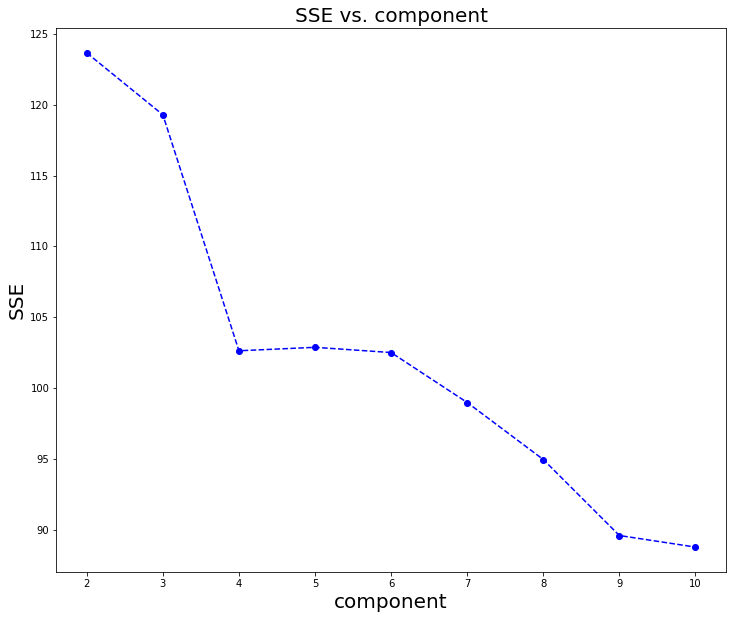

In [0]:
#create a figure for visualization 
plt.figure(figsize=(12, 10)) 
plt.plot(centers, score_list_gmm, linestyle='--', marker='o', color='b');
plt.xlabel('component', fontsize=20)
plt.ylabel('SSE', fontsize=20)
plt.title('SSE vs. component', fontsize=20)
plt.show()

In [0]:
score_list_gmm

[123.65831362844762,
 119.28943017322273,
 102.62361975987397,
 102.86692567828132,
 102.4987157552235,
 98.96967491422197,
 94.94350365473056,
 89.5767014511588,
 88.75961816820413]

#### as shown above , gmm has significantly less SSE error than the KMeans algorithim


In [0]:
#using elbow rule components = 9 was chosen 

#creating new gmm model with components =8
gmm_model = GaussianMixture(n_components=9, random_state=42)


#fitting kmeans model to the azdias_pca
gmm_model.fit(azdias_pca)



GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=9, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [0]:

#creating dump file with
filename_gmm = '/content/drive/My Drive/data capstone/gmm_model.sav'
pickle.dump(gmm_model, open(filename_gmm, 'wb'))

In [0]:
#import pickle
#loading in kmeans_model
#loaded_km_model = pickle.load(open(filename_km, 'rb'))

In [0]:
#predicting clusters
gmm_azdias = gmm_model.predict(azdias_pca)

In [0]:
sil_Score_gmm_az= silhouette_score(azdias_pca, gmm_azdias)
sil_Score_gmm_az

-0.012259899793620615

##### as shown abve difference of both models doesn't exceed 0.04 in silhouette score in favor of Kmeans model 
##### therefore model with the lower SSE will be chosen(GMM)

In [0]:
#creating Dataframe analyzing percentage of population in each cluster

#creating a series out of the labeled azdias gmm model
comp_count = pd.Series(gmm_azdias).value_counts()

#create a dataframe of percentage of population in each cluster 
comp_azdias = pd.DataFrame({'cluster': comp_count.index,
                           '% of data': 100*comp_count.values/len(gmm_azdias)})

#adding a new column indicating the data belongs to azdias data
comp_azdias['data'] = 'azdias'


comp_azdias

,cluster,% of data,data
0,2,33.865698,azdias
1,7,12.942537,azdias
2,0,12.055871,azdias
3,4,10.536583,azdias
4,8,8.277452,azdias
5,1,7.523730,azdias
6,3,6.744412,azdias
7,6,6.415112,azdias
8,5,1.638605,azdias


#### as shown above , little under 60% of the population are in cluster 0,2 and 7

In [0]:
#attempt same steps to customers data
gmm_customer= gmm_model.predict(customer_pca)

In [0]:
#creating Dataframe analyzing percentage of customers in each cluster

#creating a series out of the labeled customers gmm model
cmp_count = pd.Series(gmm_customer).value_counts()

#create a dataframe of percentage of population in each cluster 
comp_customers = pd.DataFrame({'cluster': cmp_count.index,
                           '% of data': 100*cmp_count.values/len(gmm_customer)})

#adding a new column indicating the data belongs to customers data
comp_customers['data'] = 'customers'


comp_customers

,cluster,% of data,data
0,0,31.077576,customers
1,7,17.926357,customers
2,3,14.391672,customers
3,2,10.263480,customers
4,4,9.741222,customers
5,1,9.146289,customers
6,6,6.104651,customers
7,8,1.348752,customers


#### as shown above around 50% of customers are centered around cluster 0 and 7

### comparing customers data to general population

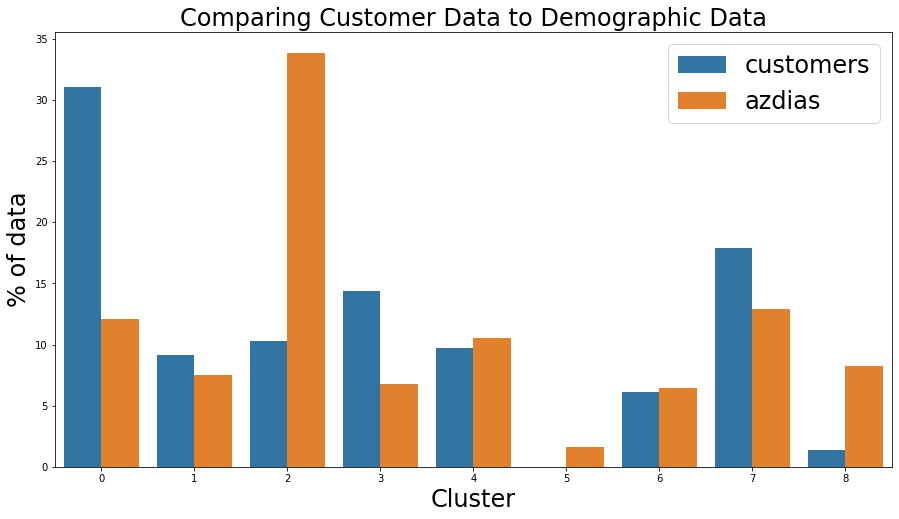

In [0]:
plt.figure(figsize=(15, 8))
sns.barplot(x="cluster", y="% of data", hue="data",
            data=pd.concat([comp_customers, comp_azdias]))
plt.xlabel('Cluster', fontsize=24)
plt.ylabel('% of data', fontsize=24)
plt.title('Comparing Customer Data to Demographic Data', fontsize=24)
plt.legend(fontsize=24)
plt.show()

#### as shown above, customers in  clusters 0,3 and 7 are over represented 
#### while customers in clusters 2, 8 are severely under represented 
#### cluster 5 has no customers

##### taking a look at an example cluster that are under represented by customers, cluster 8 was chosen as an example 
##### taking a look at an example cluster that are over represented by customers, cluster 0 was chosen as an example 
##### taking a look at an example cluster that has no customers, cluster 5 was chosen

In [0]:
#creating dataframe of clusters means  after inversing their PCA and scaling
features_means = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(gmm_model.means_)),
                              columns=clean_customers.columns)
features_means

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,...,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_INTL_2015_household,CAMEO_INTL_2015_stage,PRAEGENDE_JUGENDJAHRE_GEN,PRAEGENDE_JUGENDJAHRE_MOV,LP_LEBENSPHASE_FEIN_STAGE,LP_LEBENSPHASE_FEIN_SCALE
0,3.239995,11.511590,5.219184,0.029858,0.153912,2.048830,4.849029,0.006685,3.061912,4.337743,20.478961,4.915605,3.394477,3.159314,2.884426,2.611295,3.713259,3.554090,3.670496,3.755854,-0.014622,-0.028378,9.921193,0.500719,0.009062,0.008708,9.996200,9.944268,0.030090,0.002082,0.962245,1.963418,1.681071,0.725752,2.776231,-0.001542,1.029851,0.481440,0.926848,0.780380,...,2.851127,4.559368,4.929650,3.773221,4.279746,4.481281,3.837141,4.768429,3.537465,3.735355,3.578668,3.532510,4.080644,3.378784,4.396261,1.633270,0.008852,2.469771,3.068231,4.212078,0.079237,4.253418,0.515215,0.977119,2.363981,4.853527,5.836817,4.408920,4.177870,8.123242,4.084731,2.938078,0.531315,3.061696,1.916482,2.164725,2.940127,0.653810,2.639425,2.256639
1,3.242199,14.122985,5.757289,0.020901,0.307622,2.216604,5.183109,0.004184,3.107379,4.143723,21.612174,5.173609,3.794591,2.646066,3.504850,3.258196,3.138750,2.929950,3.079211,3.165499,0.147156,0.470209,8.441618,2.313181,1.864732,0.023158,9.604396,9.142901,0.005624,1.323951,0.868987,2.160388,1.289652,-0.003864,2.757699,1.305779,1.492262,0.704076,1.339081,-0.005790,...,3.282871,4.635394,4.478428,4.121014,4.285227,4.389981,4.281051,4.154163,3.903927,4.358321,4.046890,4.120724,4.212747,3.911198,4.312651,1.531688,0.009107,2.517418,3.347757,4.095447,0.116283,4.323680,0.536050,0.931667,2.363089,4.018056,5.523231,4.690781,3.507479,7.585063,4.069335,3.196684,0.520989,2.674664,2.047270,1.942095,3.681307,0.703800,2.220169,2.093600
2,5.909267,7.846494,9.788798,0.042967,0.038651,1.182190,9.009959,0.003552,3.301039,4.060583,26.574222,6.160657,3.333953,3.682003,3.284916,3.131372,3.228200,3.414563,3.237794,3.431482,-0.007617,-0.018087,9.985633,-0.014008,-0.006260,0.009882,10.023149,10.002505,-0.005908,-0.001065,-0.000563,0.203324,0.096002,0.005035,0.626465,-0.002560,-0.005161,-0.015313,0.005878,0.006572,...,2.879890,4.616882,4.673567,4.158735,4.407091,4.744480,4.090373,4.361187,3.934396,4.269472,3.939787,4.077151,4.074485,3.705117,4.049490,1.515124,0.007745,2.604395,3.201048,3.866339,0.073079,4.893170,0.575174,-0.002627,2.481839,8.173418,9.870026,7.531515,4.977984,8.462574,4.009933,3.671708,0.545546,2.826653,2.624433,1.655511,3.324395,0.808655,2.619637,1.713103
3,2.544210,15.123013,2.641767,0.013677,0.274951,2.872210,2.418840,0.005798,2.877462,4.712120,17.072745,4.268592,3.642676,2.595695,3.196384,2.844147,3.489628,3.162886,3.437641,3.458738,0.153059,0.460613,8.333328,2.900826,1.663132,1.323034,9.493689,9.162572,-0.002086,1.953167,1.738029,3.050820,1.829370,2.127295,3.738175,0.968161,2.191589,1.041073,2.109140,1.889442,...,3.261126,4.535696,4.665930,3.896050,4.150229,4.206835,4.095003,4.420237,3.718547,4.039514,3.870655,3.816961,4.129453,3.743026,4.496033,1.538029,0.009835,2.300227,3.337283,4.298820,0.099204,3.462728,0.489947,1.087057,2.224675,3.241595,4.408351,3.658997,3.153264,8.350933,4.411699,2.640869,0.521242

### investigating overrepresented cluster 0

In [0]:
#top 5 principal components of cluster 0
top_pc_0 = gmm_model.means_[0]
top_pc_0 = pd.Series(top_pc_0)
top_pc_0.sort_values(ascending=False, inplace=True)
top_pc_0.head(5)

0     2.640152
3     2.235730
4     0.761265
6     0.549141
29    0.456388
dtype: float64

In [0]:
# Plot thresh_feat features with the most positive and negative variance
# for a component_num PCA component
def pca_comp_corr(df, pca, component_num, thresh_feat, show_plot=True):
    
    # Build a dataframe with thresh_feat features capturing most variability
    # for a given component number (component_num)
    pca_comp = pd.DataFrame(np.round(pca.components_, 4), columns=df.keys()).iloc[component_num - 1]
    pca_comp.sort_values(ascending=False, inplace=True)
    pca_comp = pd.concat([pca_comp.head(thresh_feat), pca_comp.tail(thresh_feat)])
    
    if show_plot:
        # Plot the result
        pca_comp.plot(kind='bar', 
                  title='Most {} weighted features for PCA component {}'.format(thresh_feat*2, component_num),
                  figsize=(12, 6))
        plt.show()
    
    return pca_comp


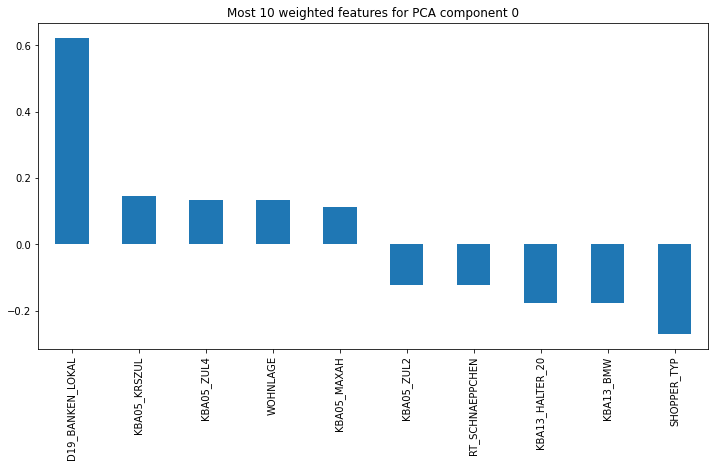

D19_BANKEN_LOKAL    0.6226
KBA05_KRSZUL        0.1458
KBA05_ZUL4          0.1330
WOHNLAGE            0.1325
KBA05_MAXAH         0.1113
KBA05_ZUL2         -0.1217
RT_SCHNAEPPCHEN    -0.1226
KBA13_HALTER_20    -0.1771
KBA13_BMW          -0.1773
SHOPPER_TYP        -0.2712
Name: 89, dtype: float64

In [0]:
# investigate first top principal components for cluster 0

pca_comp_corr(clean_customers, pca, 0, 5, True)

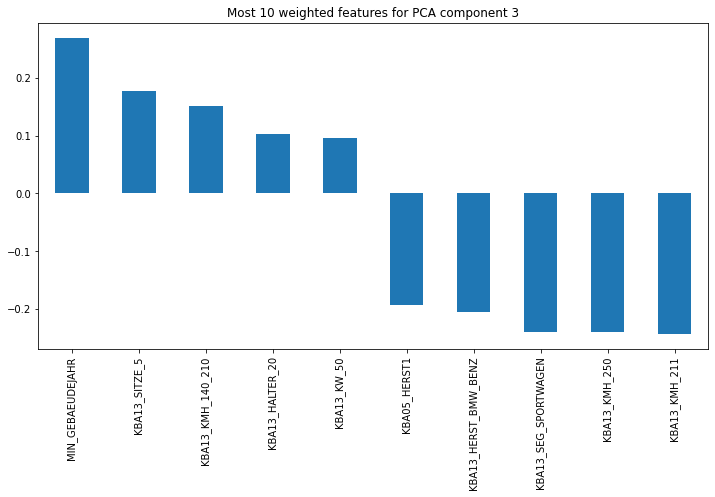

MIN_GEBAEUDEJAHR        0.2691
KBA13_SITZE_5           0.1766
KBA13_KMH_140_210       0.1518
KBA13_HALTER_20         0.1022
KBA13_KW_50             0.0963
KBA05_HERST1           -0.1922
KBA13_HERST_BMW_BENZ   -0.2050
KBA13_SEG_SPORTWAGEN   -0.2392
KBA13_KMH_250          -0.2402
KBA13_KMH_211          -0.2435
Name: 2, dtype: float64

In [0]:
# investigate second top principal components for cluster 0

pca_comp_corr(clean_customers, pca, 3, 5, True)

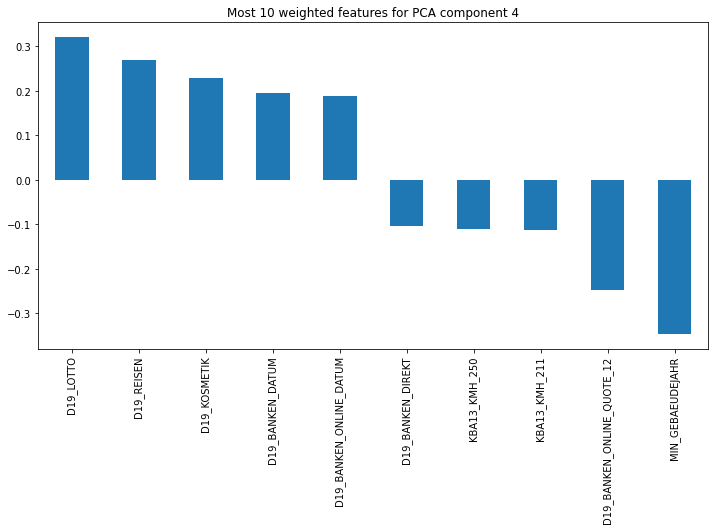

D19_LOTTO                     0.3206
D19_REISEN                    0.2686
D19_KOSMETIK                  0.2286
D19_BANKEN_DATUM              0.1955
D19_BANKEN_ONLINE_DATUM       0.1890
D19_BANKEN_DIREKT            -0.1047
KBA13_KMH_250                -0.1110
KBA13_KMH_211                -0.1120
D19_BANKEN_ONLINE_QUOTE_12   -0.2471
MIN_GEBAEUDEJAHR             -0.3457
Name: 3, dtype: float64

In [0]:
# investigate third top principal components for cluster 0

pca_comp_corr(clean_customers, pca, 4, 5, True)

### observation for over represented cluster
#### people in the under represented cluster have the following features

##### 'D19_BANKEN_LOKALKBA05_KRSZUL', 
##### 'KBA05_ZUL4',
##### 'WOHNLAGE',
##### 'KBA05_MAXAH',
##### 'MIN_GEBAEUDEJAHR',
##### 'KBA13_SITZE_5',
##### 'KBA13_KMH_140_210',
##### 'KBA13_HALTER_20',
##### 'KBA13_KW_50',
##### 'D19_LOTTO',
##### 'D19_REISEN',
##### 'D19_KOSMETIK',
##### 'D19_BANKEN_DATUM',
##### 'D19_BANKEN_ONLINE_DATUM'


In [0]:
#investigating underrepresented cluster 8

#top 5 principal components of cluster 8
top_pc_8 = gmm_model.means_[8]
top_pc_8 = pd.Series(top_pc_8)
top_pc_8.sort_values(ascending=False, inplace=True)
top_pc_8.head(5)

7     1.250155
2     0.542815
24    0.322386
64    0.267544
13    0.249298
dtype: float64

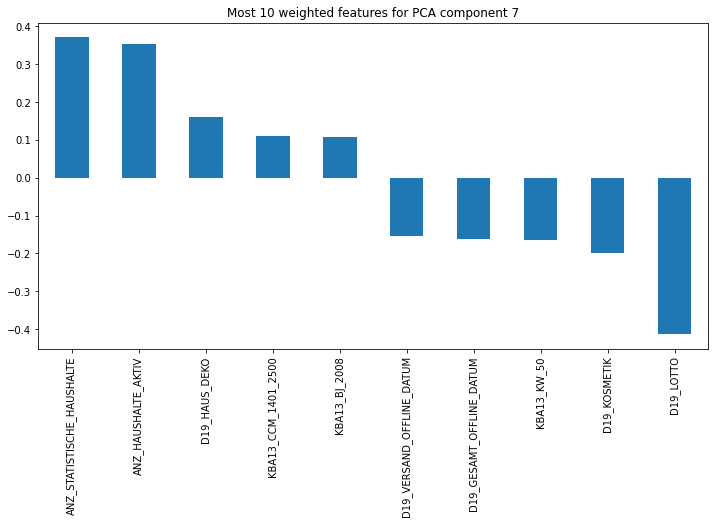

ANZ_STATISTISCHE_HAUSHALTE    0.3702
ANZ_HAUSHALTE_AKTIV           0.3524
D19_HAUS_DEKO                 0.1596
KBA13_CCM_1401_2500           0.1092
KBA13_BJ_2008                 0.1065
D19_VERSAND_OFFLINE_DATUM    -0.1531
D19_GESAMT_OFFLINE_DATUM     -0.1621
KBA13_KW_50                  -0.1655
D19_KOSMETIK                 -0.1988
D19_LOTTO                    -0.4121
Name: 6, dtype: float64

In [0]:
# investigate first top principal components for cluster 8

pca_comp_corr(clean_customers, pca, 7, 5, True)

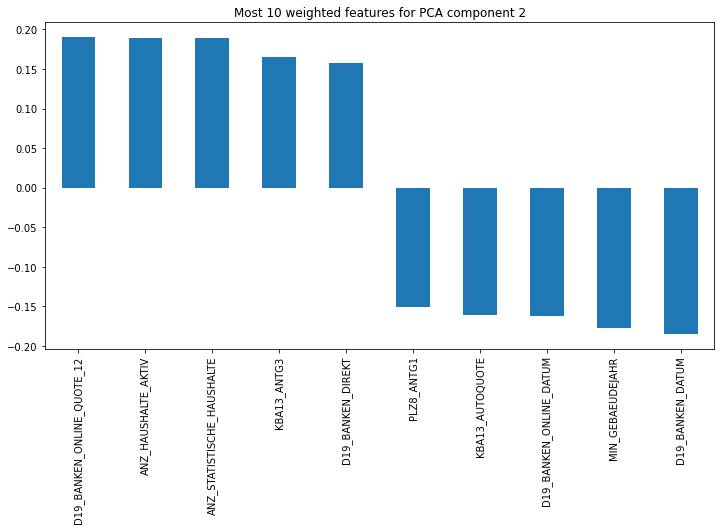

D19_BANKEN_ONLINE_QUOTE_12    0.1902
ANZ_HAUSHALTE_AKTIV           0.1896
ANZ_STATISTISCHE_HAUSHALTE    0.1894
KBA13_ANTG3                   0.1648
D19_BANKEN_DIREKT             0.1579
PLZ8_ANTG1                   -0.1507
KBA13_AUTOQUOTE              -0.1612
D19_BANKEN_ONLINE_DATUM      -0.1621
MIN_GEBAEUDEJAHR             -0.1778
D19_BANKEN_DATUM             -0.1846
Name: 1, dtype: float64

In [0]:
# investigate second top principal components for cluster 8
pca_comp_corr(clean_customers, pca, 2, 5, True)

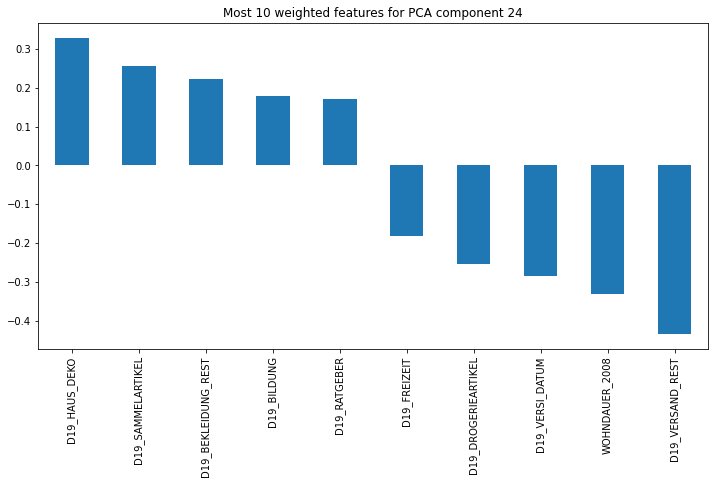

D19_HAUS_DEKO          0.3279
D19_SAMMELARTIKEL      0.2561
D19_BEKLEIDUNG_REST    0.2217
D19_BILDUNG            0.1787
D19_RATGEBER           0.1711
D19_FREIZEIT          -0.1805
D19_DROGERIEARTIKEL   -0.2540
D19_VERSI_DATUM       -0.2830
WOHNDAUER_2008        -0.3313
D19_VERSAND_REST      -0.4346
Name: 23, dtype: float64

In [0]:
# investigate third top principal components for cluster 8
pca_comp_corr(clean_customers, pca, 24, 5, True)

### most important features for under represented cluster
#### people in the under represented cluster have the following features
##### 'ANZ_STATISTISCHE_HAUSHALTE',
##### 'ANZ_HAUSHALTE_AKTIV',
##### 'KBA13_CCM_1401_2500',
##### 'KBA13_BJ_2008',
##### 'D19_BANKEN_ONLINE_QUOTE_12',
##### 'KBA13_ANTG3',
##### 'D19_BANKEN_DIREKT',
##### 'D19_HAUS_DEKO',
##### 'D19_SAMMELARTIKEL',
##### 'D19_BEKLEIDUNG_REST',
##### 'D19_BILDUNG',
##### 'D19_RATGEBER'



In [0]:
#investigating cluster with no customer representation


#top 5 principal components of cluster 5
top_pc_5 = gmm_model.means_[5]
top_pc_5 = pd.Series(top_pc_5)
top_pc_5.sort_values(ascending=False, inplace=True)
top_pc_5.head(5)

4    7.946779
0    7.623601
5    4.281092
2    3.984800
9    1.291436
dtype: float64

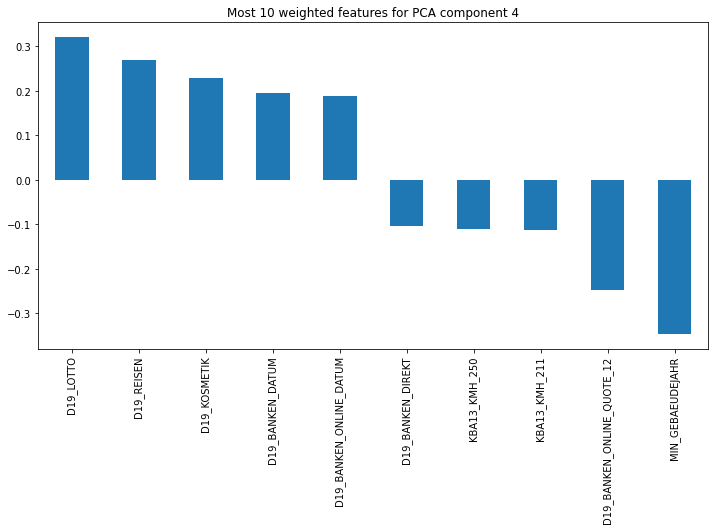

D19_LOTTO                     0.3206
D19_REISEN                    0.2686
D19_KOSMETIK                  0.2286
D19_BANKEN_DATUM              0.1955
D19_BANKEN_ONLINE_DATUM       0.1890
D19_BANKEN_DIREKT            -0.1047
KBA13_KMH_250                -0.1110
KBA13_KMH_211                -0.1120
D19_BANKEN_ONLINE_QUOTE_12   -0.2471
MIN_GEBAEUDEJAHR             -0.3457
Name: 3, dtype: float64

In [0]:
# investigate first top principal components for cluster 5
pca_comp_corr(clean_customers, pca, 4, 5, True)

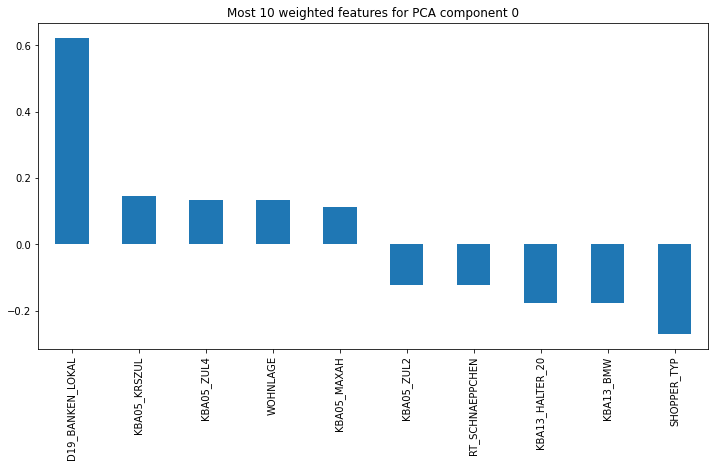

D19_BANKEN_LOKAL    0.6226
KBA05_KRSZUL        0.1458
KBA05_ZUL4          0.1330
WOHNLAGE            0.1325
KBA05_MAXAH         0.1113
KBA05_ZUL2         -0.1217
RT_SCHNAEPPCHEN    -0.1226
KBA13_HALTER_20    -0.1771
KBA13_BMW          -0.1773
SHOPPER_TYP        -0.2712
Name: 89, dtype: float64

In [0]:
# investigate second top principal components for cluster 5
pca_comp_corr(clean_customers, pca, 0 , 5, True)

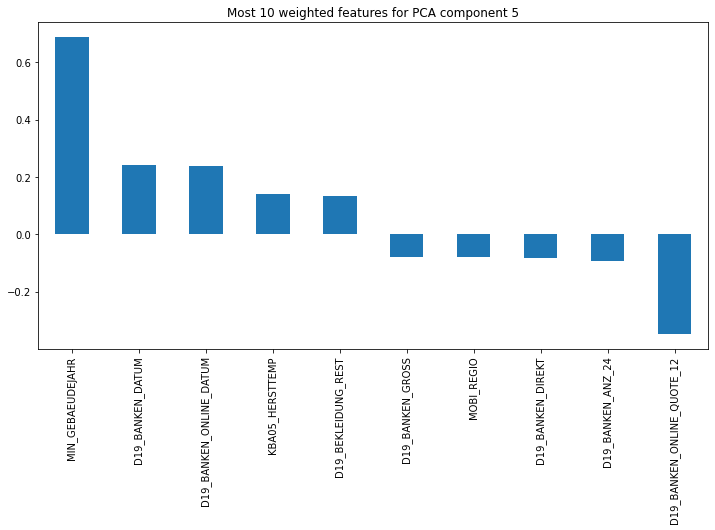

MIN_GEBAEUDEJAHR              0.6870
D19_BANKEN_DATUM              0.2410
D19_BANKEN_ONLINE_DATUM       0.2386
KBA05_HERSTTEMP               0.1403
D19_BEKLEIDUNG_REST           0.1336
D19_BANKEN_GROSS             -0.0780
MOBI_REGIO                   -0.0796
D19_BANKEN_DIREKT            -0.0819
D19_BANKEN_ANZ_24            -0.0939
D19_BANKEN_ONLINE_QUOTE_12   -0.3466
Name: 4, dtype: float64

In [0]:
# investigate third  top principal components for cluster 5
pca_comp_corr(clean_customers, pca, 5, 5, True)

### observation for cluster with no customers
#### people in cluster with no customerss have the following features
##### 'D19_LOTTO',
##### 'D19_REISEN',
##### 'D19_KOSMETIK',
##### 'D19_BANKEN_LOKAL',
##### 'KBA05_KRSZUL',
##### 'KBA05_ZUL4',
##### 'WOHNLAGE',
##### 'KBA05_MAXAH',
##### 'MIN_GEBAEUDEJAHR',
##### 'D19_BANKEN_DATU',
##### 'D19_BANKEN_ONLINE_DATUM',
##### 'KBA05_HERSTTEMP',
##### 'D19_BEKLEIDUNG_REST']

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [0]:
#Reading in data
train = pd.read_csv('/content/drive/My Drive/data capstone/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=False)

In [0]:
train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,5D,5,34,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,5.0,5.0,2.0,5.0,1.0,6,7,2,6,6,1,7,1,3,2,1,5,1,3,3,0.0,3.0,0.0,2.0,4.0,0.0,4.0,2,1.0,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,5.0,5B,5,32,2.0,2.0,2.0,2.0,4.0,3.0,5.0,4.0,1,1,5,0,0,3,10,10,0.0,0,0,6,...,1.0,2.0,3.0,1.0,3.0,6,6,1,5,6,3,6,5,5,4,3,1,3,4,2,0.0,1.0,0.0,2.0,5.0,0.0,0.0,1,1.0,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,1.0,2D,2,14,4.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,1,7,0,0,0,10,7,0.0,5,0,0,...,4.0,3.0,1.0,5.0,2.0,3,3,4,1,3,4,7,6,1,1,5,3,1,7,3,0.0,3.0,0.0,1.0,5.0,0.0,10.0,1,4.0,1.0,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,2.0,2D,2,14,2.0,5.0,2.0,2.0,5.0,5.0,5.0,4.0,0,0,10,0,0,0,10,10,0.0,0,0,6,...,3.0,5.0,2.0,5.0,1.0,5,7,1,6,7,1,7,1,4,2,2,5,3,2,1,0.0,3.0,0.0,3.0,5.0,0.0,5.0,2,1.0,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,4.0,7B,7,41,6.0,5.0,1.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,5,0,...,3.0,5.0,1.0,5.0,1.0,5,4,6,2,5,5,6,6,4,5,4,6,2,7,1,0.0,3.0,0.0,2.0,5.0,0.0,4.0,1,0.0,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [0]:
train.shape

(42962, 367)

In [0]:
train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [0]:
#calculating reponse rate
responded_percentage = train['RESPONSE'].value_counts()[1]/train['RESPONSE'].value_counts()[0] *100 
print('customers responded =',responded_percentage , '%')
print('customers ignored =', 100 - responded_percentage , '%')

customers responded = 1.253829837379213 %
customers ignored = 98.74617016262079 %


#### as shown above , response classes are highly unbalanced  with only 1.25% reponse rate
#### therefore will set the class balance to ''balanced'' in estimators whenever possible

In [0]:
#checking to see if same columns will be dropped 
train = replace_unknown_with_nan(train, feat_info, 'Attribute', 'Value')

In [0]:
#creating dataframe of missing values percentages for columns
total_train = train.isnull().sum().sort_values(ascending=False)
percent_train = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data_train = pd.concat([total_train, percent_train], axis=1, keys=['Total', 'Percent'])

In [0]:
missing_data_train.head(10)

,Total,Percent
ALTER_KIND4,42921,0.999046
ALTER_KIND3,42788,0.995950
TITEL_KZ,42749,0.995042
ALTER_KIND2,42206,0.982403
ALTER_KIND1,40974,0.953727
KK_KUNDENTYP,25316,0.589265
KBA05_BAUMAX,22980,0.534891
AGER_TYP,17963,0.418114
EXTSEL992,15948,0.371212
W_KEIT_KIND_HH,10417,0.242470


### cleaning train data
#### setting drop_rows to False as response classes are highly unbalanced and cannot afford to lose positive reponse observations

In [0]:
#cleaning training date
clean_train = clean_data(train, feat_info, False)
clean_train.shape

(42962, 353)

In [0]:
#saving and removing the response column
response = clean_train['RESPONSE']

clean_train.drop(['RESPONSE'], axis=1, inplace=True)

In [0]:
clean_train.shape

(42962, 352)

In [0]:
clean_train.isnull().sum()

AKT_DAT_KL                   0
ALTER_HH                     0
ANZ_HAUSHALTE_AKTIV          0
ANZ_HH_TITEL                 0
ANZ_KINDER                   0
                            ..
CAMEO_INTL_2015_stage        0
PRAEGENDE_JUGENDJAHRE_GEN    0
PRAEGENDE_JUGENDJAHRE_MOV    0
LP_LEBENSPHASE_FEIN_STAGE    0
LP_LEBENSPHASE_FEIN_SCALE    0
Length: 352, dtype: int64

In [0]:
#scale train data
scaled_train = pd.DataFrame((scaler.fit_transform(clean_train.values)), columns=clean_train.columns)

### Creating Machine Learning models 

In [0]:
#create a gridsearchCV function to test models and their score and return AUC-ROC score
def model_grid(model, param, X_train=scaled_train, y_train=response):
    """
    Fits a model to its training data and prints its ROC AUC score.
    
    INPUT:
    - model: model to fit
    - param (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - model: input model fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    grid = GridSearchCV(estimator=model, param_grid=param, scoring='roc_auc', cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    
    return grid.best_estimator_

In [0]:
rf = RandomForestRegressor(random_state=42)
model_grid(rf,{})

0.7048612968021268


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [0]:
xgb = XGBRegressor(objective='binary:logistic', random_state=42)
model_grid(xgb,{})

0.7572387214697314


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='binary:logistic',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [0]:
gb = GradientBoostingRegressor(random_state=42)
model_grid(gb,{})

0.7535573144172779


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
lgbc = lgb.LGBMClassifier(application='binary', random_state=42)

model_grid(lgbc,{})

0.7011015726712928


LGBMClassifier(application='binary', boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [0]:
#splitting data to test data and train data
X_train, X_test, y_train, y_test = train_test_split(scaled_train, response, stratify=response, test_size=0.2, random_state=42)

### Hyper Parameter Tuning
#### #RnadomizedSearchCv was chosen as it's faster in finding optimal estimator parameters

In [0]:
#creating random search Function that tests parameters for models and returns model parameters with best score


def random_search(pipeline, parameters, X_train, y_train, X_test, y_test, n_iter=None):
    
    start = time.time() 
    

    grid_obj = RandomizedSearchCV(estimator=pipeline,
                            param_distributions=parameters,
                            cv=5,
                            n_iter=n_iter,
                            refit=True,
                            return_train_score=False,
                            scoring = 'roc_auc',
                            random_state=1)
    grid_obj.fit(X_train, y_train,)
    

    estimator = grid_obj.best_estimator_
    cvs = cross_val_score(estimator, X_train, y_train,scoring = 'roc_auc', cv=5)
    results = pd.DataFrame(grid_obj.cv_results_)
    
    print("##### Results")
    print("Score best parameters: ", grid_obj.best_score_)
    print("Best parameters: ", grid_obj.best_params_)
    print("Cross-validation Score: ", cvs.mean())
    print("Test Score: ", estimator.score(X_test, y_test))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ",results.shape[0])
    
    return results, estimator

In [0]:
#storing parameters to be tested for XGB And LGB Models



pipe_lgb = pipeline.Pipeline([
    ('clf', lgb.LGBMClassifier(application='binary',
        metric='auc',
        n_jobs=-1,
        verbose=0))
    ])


pipe_xgb = pipeline.Pipeline([
    ('clf', XGBRegressor(objective = 'binary:logistic',
        eval_metric ='auc',
        n_jobs=-1))
    ])





param_xgb = {
        'clf__learning_rate':  list(np.logspace(np.log(0.01), np.log(1), num = 500, base=3)),
        'clf__max_depth': list(range(1, 15,2)),
        'clf__min_child_weight': (1, 10),
        'clf__gamma': (0.0, 1.0),
        'clf__subsample': (0.5, 1.0),
        'clf__colsample_bytree': list(np.linspace(0.5, 1, 500)),
        'clf__reg_alpha': (1e-9, 1.0),
        'clf__reg_lambda': list(np.linspace(0, 1, 500)),

        'clf__n_estimators': list(range(50, 500,50)),
        'clf__scale_pos_weight': (1,90),
  
        'clf__max_delta_step' : (0, 10),
        'clf__colsample_bylevel': (0.01, 1.0),
        'clf__reg_lambda': (1e-9, 100),
        'clf__scale_pos_weight': (1, 90)
    }


param_lgb = {
    'clf__learning_rate': list(np.logspace(np.log(0.01), np.log(1), num = 500, base=3)),
    'clf__max_depth': list(range(5, 15)),
    'clf__n_estimators': list(range(5, 35)),
    'clf__num_leaves': list(range(5, 50)),
    'clf__boosting_type': ['gbdt', 'dart'],
    'clf__colsample_bytree': list(np.linspace(0.6, 1, 500)),
    'clf__reg_lambda': list(np.linspace(0, 1, 500)),
}


In [0]:
#testing for best Lgb parammters and setting number of evaluations to 100
num_eval =100
results_random, estimator_random = random_search(pipe_lgb, param_lgb, X_train, y_train, X_test, y_test, num_eval)

##### Results
Score best parameters:  0.768775981694969
Best parameters:  {'clf__reg_lambda': 0.10420841683366733, 'clf__num_leaves': 23, 'clf__n_estimators': 18, 'clf__max_depth': 14, 'clf__learning_rate': 0.029955290770426184, 'clf__colsample_bytree': 0.6977955911823647, 'clf__boosting_type': 'dart'}
Cross-validation Score:  0.768775981694969
Test Score:  0.9876643779820784
Time elapsed:  497.4775016307831
Parameter combinations evaluated:  100


### as shown above hyperparameter tuned lgbm model has reach 0.768 auc score

In [0]:
#show best parameters for estimator
estimator_random

Pipeline(memory=None,
         steps=[('clf',
                 LGBMClassifier(application='binary', boosting_type='dart',
                                class_weight=None,
                                colsample_bytree=0.6977955911823647,
                                importance_type='split',
                                learning_rate=0.029955290770426184,
                                max_depth=14, metric='auc',
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=18, n_jobs=-1,
                                num_leaves=23, objective=None,
                                random_state=None, reg_alpha=0.0,
                                reg_lambda=0.10420841683366733, silent=True,
                                subsample=1.0, subsample_for_bin=200000,
                                subsample_freq=0, verbose=0))],
         verbose=False)

In [0]:
##testing for best xgboost parammters and setting number of evaluations to 100
num_eval =75
results_random2, estimator_random2 = random_search(pipe_xgb, param_xgb, X_train, y_train, X_test, y_test, num_eval)

##### Results
Score best parameters:  0.7650300808938446
Best parameters:  {'clf__subsample': 1.0, 'clf__min_child_weight': 10, 'clf__max_depth': 3, 'clf__learning_rate': 0.09045413130659352, 'clf__gamma': 1.0, 'clf__colsample_bytree': 0.6412825651302605}
Cross-validation Score:  0.7650300808938446
Test Score:  0.011127136571474017
Time elapsed:  4897.51881480217
Parameter combinations evaluated:  75


#### as shown above hyperparameter tuned xgb model has reach  0.765 auc score

In [0]:
#show best params for xgboost estimator
estimator_random2

Pipeline(memory=None,
         steps=[('clf',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.6412825651302605,
                              eval_metric='auc', gamma=1.0,
                              importance_type='gain',
                              learning_rate=0.09045413130659352,
                              max_delta_step=0, max_depth=3,
                              min_child_weight=10, missing=None,
                              n_estimators=100, n_jobs=-1, nthread=None,
                              objective='binary:logistic', random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              seed=None, silent=None, subsample=1.0,
                              verbosity=1))],
         verbose=False)

#### as difference in auc score is almost negliible , XGBOOST model will be used

In [0]:
#setting XGBREGRESSOR as our final model with hyper parameter tuned
model = XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.6412825651302605,
                              eval_metric='auc', gamma=1.0,
                              importance_type='gain',
                              learning_rate=0.09045413130659352,
                              max_delta_step=0, max_depth=3,
                              min_child_weight=10, missing=None,
                              n_estimators=100, n_jobs=-1, nthread=None,
                              objective='binary:logistic', random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              seed=None, silent=None, subsample=1.0,
                              verbosity=1)

In [160]:
#fitting the model on scaled_train and response column and setting evaluation metric to auc
model.fit(scaled_train, response, eval_metric='auc')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6412825651302605,
             eval_metric='auc', gamma=1.0, importance_type='gain',
             learning_rate=0.09045413130659352, max_delta_step=0, max_depth=3,
             min_child_weight=10, missing=None, n_estimators=100, n_jobs=-1,
             nthread=None, objective='binary:logistic', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1.0, verbosity=1)

In [0]:
#create pickle file to store model
#filename_xgb = '/content/drive/My Drive/data capstone/xbg_model.sav'

#pickle.dump(model , open(filename_xgb, 'wb'))

In [0]:
# storing important features for model
important_features = pd.Series(model.feature_importances_,
                     index=scaled_train.columns).sort_values(ascending=False)
                    

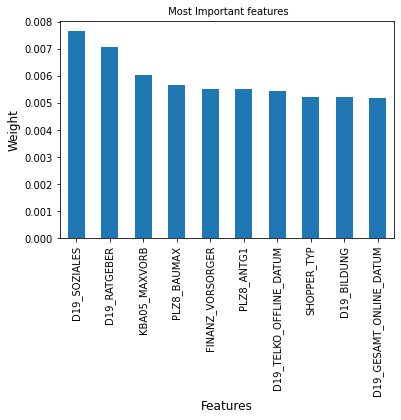

In [0]:
# plot 10 most important features
fig = plt.figure()
important_features.iloc[:10].plot(kind='bar')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Weight', fontsize=12)
plt.title(' Most Important features', fontsize=10)
plt.show()

#### as shows above the 10 most important features in predicting cutomer response and top 2 features are 'D19_SOZIALES' AND 'D19_RATGEBER'

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [0]:
#reading in test data
test = pd.read_csv('/content/drive/My Drive/data capstone/Udacity_MAILOUT_052018_TEST.csv', sep=';', low_memory=False)

In [162]:
test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,6.0,2B,2,13,5.0,5.0,1.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,3,6,...,3.0,4.0,5.0,2.0,5.0,1.0,3,3,4,2,3,6,7,1,1,1,2,6,1,7,3,0.0,3.0,0.0,2.0,5.0,0.0,23.0,1,1.0,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,0.0,0.0,1.0,21.0,0.0,4.0,7.0,5A,5,31,1.0,5.0,2.0,2.0,5.0,5.0,4.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,6,...,4.0,5.0,5.0,1.0,5.0,1.0,3,7,4,3,3,4,5,4,3,3,3,6,1,6,2,0.0,3.0,0.0,4.0,3.0,0.0,0.0,1,1.0,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,0.0,0.0,4.0,2.0,0.0,4.0,1.0,7A,7,41,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,6.0,5.0,5.0,2.0,5.0,1.0,5,7,1,6,4,2,7,1,4,3,1,4,3,3,3,0.0,3.0,0.0,1.0,5.0,1.0,15.0,1,1.0,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,2B,2,13,4.0,5.0,2.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,5.0,4.0,5.0,1.0,3.0,1.0,5,7,1,6,7,2,7,2,2,3,2,3,3,2,3,0.0,3.0,0.0,2.0,5.0,0.0,10.0,2,1.0,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,6.0,5A,5,31,6.0,1.0,3.0,2.0,4.0,4.0,4.0,3.0,3,4,2,2,2,0,8,2,10.0,6,6,6,...,4.0,2.0,3.0,3.0,2.0,3.0,6,7,2,5,4,2,5,2,3,3,2,5,3,3,3,0.0,2.0,0.0,5.0,5.0,0.0,0.0,1,1.0,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [163]:
test.shape

(42833, 366)

In [0]:
#storing in LNR column as will be needed later to map it with predictions to submit results to Kaggle
lnr = test['LNR']

In [165]:
#clean test data
clean_test = clean_data(test, feat_info, False)
clean_test.shape

(42833, 352)

In [0]:
#scale data
scaled_test = pd.DataFrame(scaler.transform(clean_test.values),
                        columns= clean_test.columns)

In [0]:
#re-aligning columns to be in line with scaled_train columns
scaled_test = scaled_test[scaled_train.columns]

In [0]:
#loaded_xgb_model = pickle.load(open(filename_xgb, 'rb'))

In [0]:
#create predictions
predictions = model.predict(scaled_test)

In [169]:
#finally create competetion submission

comp_sub = pd.DataFrame(predictions, index=lnr.astype('int32'),
                          columns=["RESPONSE"])

comp_sub.head()

,RESPONSE
LNR,
1754,0.040057
1770,0.033246
1465,0.003641
1470,0.003396
1478,0.004667


In [0]:
comp_sub.to_csv('/content/drive/My Drive/data capstone/comp_sub.csv', sep=',')